<a href="https://colab.research.google.com/github/ccarpenterg/LearningTensorFlow2.0/blob/master/Gettingstarted_TensorFlow2_0_CIFAR_10_Pre_trained_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CIFAR-10: Fine-tuning a pre-trained convnet

So now we're going to fine-tune a pretrained convnet: VGG16. We'll use this CNN to extract features of our dataset and then we'll add a couple of dense layers to create our own dense classifier. This method consists of 2 parts:

1) Freeze the VGG16 CNN and train our dense classifier.

2) Unfreeze part of the VGG16 and jointly train some VGG16's layers and our dense classifier.


In [0]:
!pip install tensorflow==2.0.0-beta1

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

print(tf.__version__)

2.0.0-beta1


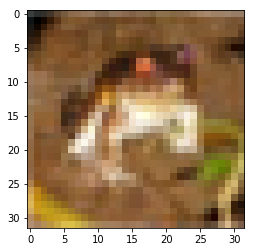

In [0]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(x_train[0])
plt.show()

### Using TensorFlow Datasets



In [0]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_train, raw_validation, raw_test), metadata = tfds.load(
            'cifar10', split=list(splits), with_info=True, as_supervised=True)

In [0]:
print(raw_train)
print(raw_validation)
print(raw_test)

<_OptionsDataset shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>


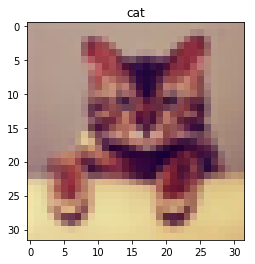

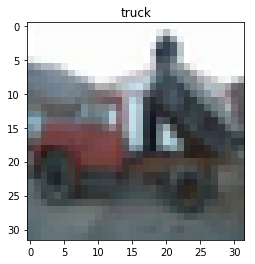

In [0]:
import matplotlib.pyplot as plt

label_names = metadata.features['label'].int2str

for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(label_names(label))

### Mapping and Transformations

In [0]:
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.
    return image, label

In [0]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

### Preparing Batches and Shuffling

In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

Now we have divided our dataset in batches of 32 examples each:

In [0]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 32, 32, 3])

First we need to download the weights of our pre-trained convnet:

In [0]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3))

In [0]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

Now let's check our feature extraction dimensions:

In [0]:
feature_batch = conv_base(image_batch)
print(feature_batch.shape)

(32, 1, 1, 512)


In [0]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 14,982,474
Trainable params: 14,982,474
Non-trainable params: 0
_________________________________________________________________


In [0]:
conv_base.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 14,982,474
Trainable params: 267,786
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
history = model.fit(x_train,
                    y_train,
                    epochs=30,
                    validation_data=(x_test, y_test))